In [1]:
import numpy as np
import nltk
import string
import os
import pandas
import matplotlib.pyplot as plt
import profanityfilter
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from scipy.interpolate import interp1d

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Python/2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df = pandas.read_csv('merged.csv')
df_sorted = df.sort(['Year'], ascending=[1])
print(df_sorted.shape)
print(df_sorted.head())

(4988, 4)
                                          Song           Artist  Year  \
0     i cant help myself sugar pie honey bunch        four tops  1965   
4109                           it aint me babe      the turtles  1965   
4110                 red roses for a blue lady         vic dana  1965   
4111                     dont just stand there       patty duke  1965   
4112                             little things  bobby goldsboro  1965   

                                                 Lyrics  
0      Ooh, sugar pie, honey bunch\nYou know that I ...  
4109   go away from my window leave at your own chos...  
4110  vic dana miscellaneous red roses for a blue la...  
4111  please dont just stand there come and kiss me ...  
4112  little things that you do  make me glad im in ...  


/Library/Python/2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  


R2 score: 0.26493386708


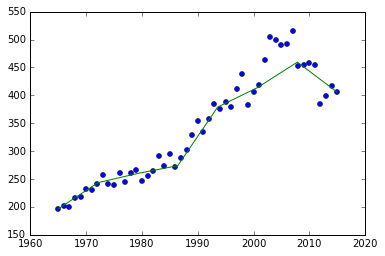

In [3]:
### Benchmark Model

# Count the number of words in each song
word_counts = [len(row[1]['Lyrics'].replace('\n', ' ').split()) for row in df_sorted.iterrows()]
X_bench = np.array(word_counts).reshape((len(word_counts), 1))
y_bench = df_sorted['Year']

# Train test split for benchmark
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size=0.2, random_state=1)

# Initiliaze and train the benchmar model
benchmark_model = LinearRegression()
benchmark_model.fit(X_train_b, y_train_b)

# Predict year using the benchmark and print r2 score
y_pred = benchmark_model.predict(X_test_b)
print('R2 score: {}'.format(r2_score(y_test_b, y_pred)))

# Plot word count average per year
aggregations = {'Lyrics': lambda x: np.mean([len(r.replace('\n', ' ').split()) for r in x])}

word_count_avg_per_year = df_sorted.groupby('Year').agg(aggregations)
x = range(1965, 2016)

# Interpolate the function
f = interp1d(np.array(x), np.array(word_count_avg_per_year).squeeze(), kind='cubic')
x_interp = np.linspace(1965, 2015, num=8, endpoint=True)

# Plot
plt.plot(x, word_count_avg_per_year, 'o', x_interp, f(x_interp), '-', color='green', markerfacecolor='blue', markersize=5)
plt.show()



In [4]:
### Vectorizing the data

stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens_filtered = filter(lambda w: not w in set(stopwords.words('english')), tokens)
    stems = stem_tokens(tokens_filtered, stemmer)
    return stems

result = []

for row in df.iterrows():
    text = row[1]['Lyrics']
    lowers = text.lower()
    no_punctuation = lowers.translate(None, string.punctuation)
    result.append(no_punctuation)

try:
    tfs = pickle.load(open("tfs.pickle", "rb"))
except (OSError, IOError) as e:
    tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english', encoding='latin-1', binary=True, sublinear_tf=True)
    tfs = tfidf.fit_transform(result)
    pickle.dump(tfs, open("tfs.pickle", "wb"))

tfs.shape

(4988, 22637)

In [5]:
### Adding relevant features
profanityfilter.append_words(['skeet', 'hoe', 'hoes', 'thot', 'thots', 'niggas', 'niggaz', 'shits', 'mothafuckin'])

# Compute profanity count average per year
aggregations = {
    'Lyrics': lambda year: np.mean([sum([r.replace('\n', ' ').lower().translate(None, string.punctuation).split().count(p.lower()) for p in profanityfilter.get_bad_words()]) for r in year])
}

try:
    profanity_count_avg_per_year = pickle.load(open("pcapy.pickle", "rb"))
except (OSError, IOError) as e:
    profanity_count_avg_per_year = df_sorted.groupby('Year').agg(aggregations)
    pickle.dump(profanity_count_avg_per_year, open("pcapy.pickle", "wb"))

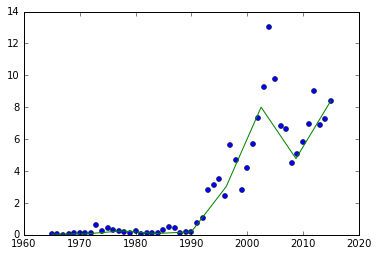

In [6]:
# Interpolate the function
f_prof = interp1d(np.array(x), np.array(profanity_count_avg_per_year).squeeze(), kind='cubic')
x_prof_interp = np.linspace(1965, 2015, num=9, endpoint=True)

# Plot profanity average per year
plt.plot(x, profanity_count_avg_per_year, 'o', x_prof_interp, f_prof(x_prof_interp), '-', color='green', markerfacecolor='blue', markersize=5)
plt.show()

In [7]:
# profanity_count = [sum([r.split().count(p.lower()) for p in profanityfilter.get_bad_words()]) for r in result]
profanity_exists = [1 if any([p in r.split() for p in profanityfilter.get_bad_words()]) else 0 for r in result]

In [21]:
tfs_profanity = np.concatenate((np.array(profanity_exists).reshape(len(profanity_exists), 1), tfs.toarray()), axis=1)
print('Dataset with profanity: {}\n'.format(tfs_profanity.shape))
word_count_per_dp = [len(r.replace('\n', ' ').split()) for r in df['Lyrics']]

tfs_profanity_wc = np.concatenate((np.array(word_count_per_dp).reshape(len(word_count_per_dp), 1), tfs_profanity), axis=1)
print('Dataset with profanity and word count shape: {}\n'.format(tfs_profanity_wc.shape))

X_train, X_test, y_train, y_test = train_test_split(tfs_profanity_wc, df['Year']-1965, test_size=0.2, random_state=2)
print('y_train samples:')
print(y_train.head())

Dataset with profanity: (4988, 22638)

Dataset with profanity and word count shape: (4988, 22639)

y_train samples:
3526    45
1847    25
3418    43
2604    34
3643    46
Name: Year, dtype: int64


In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1000, random_state=0)
pca.fit(tfs_profanity_wc)

print(pca.explained_variance_ratio_)
# rf = RandomForestRegressor(n_jobs=3, random_state=0, n_estimators=200, max_features=1000, verbose=2)
# rfecv.fit(X_train, y_train)
# print(rfecv.feature_importances_)

[[  9.99999163e-01   1.25965559e-03   1.26468094e-06 ...,   3.59791516e-07
    3.45786367e-07  -2.64830758e-07]
 [  1.26898780e-03  -9.95461288e-01   4.19264957e-04 ...,  -2.68654224e-05
   -4.59063709e-05   3.56756112e-07]
 [  8.65967375e-06   5.37148773e-02  -1.42335000e-03 ...,  -2.49201680e-04
   -1.11902679e-04  -1.79271244e-04]
 ..., 
 [  2.97871518e-06   2.14171980e-04   3.54319983e-03 ...,  -1.48491006e-03
    2.91438528e-04  -7.51128580e-04]
 [ -1.57565291e-06  -2.36420812e-04  -9.18743699e-04 ...,  -1.35409240e-03
    9.61322213e-05  -1.67180064e-03]
 [  2.46877481e-07   6.53054690e-04   1.19749916e-02 ...,  -1.48607392e-03
   -1.53132553e-04  -7.01610038e-04]]
[  9.99962362e-01   4.31339564e-06   2.21085750e-07   1.41930515e-07
   1.09363193e-07   8.93382741e-08   8.64855805e-08   7.97310674e-08
   7.69366945e-08   7.37256955e-08   7.12535625e-08   6.95921727e-08
   6.79304338e-08   6.58441047e-08   6.45986323e-08   6.43270722e-08
   6.35548241e-08   6.25407861e-08   6.23649

In [26]:
print(tfs_profanity_wc)
# tfs_post_pca = pca.transform(tfs_profanity_wc)
# rf = RandomForestRegressor(n_jobs=3, random_state=0, n_estimators=200, max_features=1000, verbose=2)
# rfecv.fit(X_train, y_train)
# print(rfecv.feature_importances_)

[[ 277.    0.    0. ...,    0.    0.    0.]
 [ 256.    0.    0. ...,    0.    0.    0.]
 [ 156.    0.    0. ...,    0.    0.    0.]
 ..., 
 [ 509.    1.    0. ...,    0.    0.    0.]
 [ 500.    1.    0. ...,    0.    0.    0.]
 [ 223.    0.    0. ...,    0.    0.    0.]]


In [114]:
print(tfs_extra[4500:4699,0])

[   0.    5.    3.    2.    3.    4.   84.    0.    3.    0.    2.    1.
    1.    3.    2.    1.    4.    4.   19.    6.    0.    0.    0.    0.
    0.    4.    0.    0.    0.    0.    4.    8.    0.    2.    0.    0.
    6.   71.    0.    4.    0.    7.    7.    0.    1.    0.   52.    0.
    2.    0.    0.    0.    9.    0.   31.    0.    1.    0.   89.    0.
    0.    0.    0.    1.   30.    0.    0.   14.    4.    0.    1.    3.
   12.    0.    0.    3.   24.    3.    0.    0.    4.    8.    0.    7.
    4.    0.    0.    0.    0.   29.   47.    0.   15.   17.    6.   26.
    0.    0.    0.    3.    0.    0.    0.    3.    0.    0.    0.    0.
    0.    0.    2.    0.    4.    0.   62.    0.    0.   30.    0.    0.
    0.    2.    0.    1.    0.    3.    1.    0.    1.    0.    0.    5.
    0.    0.  138.   13.    0.    0.    0.    0.    0.   83.    2.    2.
    3.    0.    0.    3.    0.    7.    1.    0.    0.    0.    0.    0.
    0.   21.    0.    0.    0.    0.    0.   36.   

In [116]:
print(tfidf.stop_words_)

set([])


In [129]:
nn = MLPRegressor(verbose=True, random_state=0)

In [131]:
nn.fit(X_train, y_train)

Iteration 1, loss = 417.19044830
Iteration 2, loss = 392.29534311
Iteration 3, loss = 360.19133853
Iteration 4, loss = 321.87268726
Iteration 5, loss = 279.35717593
Iteration 6, loss = 236.82128912
Iteration 7, loss = 196.82603948
Iteration 8, loss = 163.55804271
Iteration 9, loss = 137.71566626
Iteration 10, loss = 120.12403721
Iteration 11, loss = 109.25877706
Iteration 12, loss = 102.96874510
Iteration 13, loss = 99.26657544
Iteration 14, loss = 96.78552607
Iteration 15, loss = 94.70294273
Iteration 16, loss = 92.86107548
Iteration 17, loss = 91.04303567
Iteration 18, loss = 89.31344340
Iteration 19, loss = 87.56512253
Iteration 20, loss = 85.77912795
Iteration 21, loss = 83.94439747
Iteration 22, loss = 82.09259720
Iteration 23, loss = 80.25870289
Iteration 24, loss = 78.42426679
Iteration 25, loss = 76.56594769
Iteration 26, loss = 74.70570582
Iteration 27, loss = 72.85642141
Iteration 28, loss = 71.02563123
Iteration 29, loss = 69.21688291
Iteration 30, loss = 67.43792711
Iterati

/Library/Python/2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)

In [132]:
nn.score(X_test, y_test)

-0.5252850665630171